# 1. Data pre-processing

In [4]:
import warnings
warnings.filterwarnings("ignore")
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import json
import pickle
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import random
import numpy as np
import matplotlib.pyplot as plt
# Inisialisasi
factory = StemmerFactory()
stemmer = factory.create_stemmer()
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open("intents.json").read()
intents = json.loads(data_file)
# Proses mengumpulkan data percakapan dari intens.json menjadi document
for intent in intents['intents']:
    for pattern in intent['patterns']:
        w = nltk.word_tokenize(pattern)
        # Tambahkan ke dokumen dan kumpulkan kata-kata
        words.extend(w)
        documents.append((w, intent['tag']))
        # Tambahkan kelas unik
        if intent['tag'] not in classes:
            classes.append(intent['tag'])
# Buat daftar kata yang unik dan urutkan
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
classes = sorted(list(set(classes)))
print(f"{len(documents)} documents")
print (len(classes), "classes", classes)
print (len(words), "unique lemmatized words", words)
# Simpan kata dan kelas ke file dengan pickle
pickle.dump(classes, open('labels.pkl', 'wb'))
pickle.dump(words, open('texts.pkl', 'wb'))

176 documents
37 classes ['Alamat', 'Batuk', 'CPR', 'Cedera Kepala', 'Cedera otot', 'Demam', 'Diare', 'Dokter', 'Gigitan Serangga', 'Gudik', 'Jadwal', 'Kejang', 'Keseleo', 'Lecet', 'Luka Bakar Kimia', 'Maag', 'Malam', 'Mata merah', 'Memar', 'Pagi', 'Pendarahan Normal', 'Pilek', 'Pingsan', 'Racun', 'Ruam', 'Sakit Tenggorokan', 'Sakit kepala', 'Sengatan', 'Serpihan', 'Siang', 'Sore', 'Tenggelam', 'Terbakar Matahari', 'Terimakasih', 'Tersedak', 'gigitan binatang', 'gigitan ular']
131 unique lemmatized words ['', '3', 'ada', 'air', 'akibat', 'aku', 'alamat', 'alami', 'ambil', 'an-nur', 'anda', 'angkat', 'anjing', 'antara', 'apa', 'asa', 'atas', 'atau', 'badan', 'bagaimana', 'bahan', 'baik', 'bakar', 'batuk', 'berapa', 'binatang', 'bot', 'buang', 'buka', 'cara', 'cedera', 'cpr', 'dalam', 'dapat', 'darah', 'demam', 'dengan', 'di', 'diagnosis', 'diare', 'dokter', 'es', 'flu', 'gigit', 'gudik', 'guna', 'hai', 'halo', 'hari', 'harus', 'hewan', 'hilang', 'ii', 'iks', 'ingin', 'jadwal', 'jawab', 

# 2. Membuat Pelatihan Data

In [5]:
training = []
output_empty = [0] * len(classes)
for doc in documents:
    bag = []
    pattern_words = doc[0]
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # Buat 'bag' dengan panjang tetap
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # Pastikan panjang 'bag' dan 'output_row' seragam
    if len(bag) == len(words):
        output_row = list(output_empty)
        output_row[classes.index(doc[1])] = 1
        if len(output_row) == len(classes):
            training.append([bag, output_row])
random.shuffle(training)
# Ubah training menjadi numpy array
training = np.array(training, dtype=object)
# Pisahkan train_x dan train_y
train_x = np.array([item[0] for item in training], dtype=np.float32)
train_y = np.array([item[1] for item in training], dtype=np.float32)
# Reshape data ke bentuk (samples, timesteps, features) dengan timesteps=1 karena data yang digunakan bukan data time-series
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
print(train_x.shape)  # Verifikasi bentuk train_x
print(train_y.shape)  # Verifikasi bentuk train_y

(176, 1, 131)
(176, 37)


# 3. Membuat Model

In [ ]:
# Membuat model LSTM untuk memprediksi jawaban pengguna
model = Sequential()
# Input Layer LSTM dengan aktivasi tanh
model.add(LSTM(128, input_shape=(train_x.shape[1], train_x.shape[2]), activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
# Hidden Layer LSTM dengan aktivasi tanh
model.add(LSTM(256, activation='tanh'))
model.add(Dropout(0.3))
# Layer Output dengan aktivasi softmax (Berfungsi untuk memprediksi hasil berdasarkan probabilitas dari hidden layer)
model.add(Dense(len(train_y[0]), activation='softmax'))
# Compile model dengan optimizer Adam
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Pembelajaran model
hist = model.fit(
    train_x,
    train_y,
    epochs=50,
    batch_size=16,
    validation_split=0.2,  # 20% data digunakan untuk validasi
    verbose=1
)
# menyimpan model ke file models.keras
model.save('models.keras', hist)
print("\n")
print("*" * 50)
print("\nModel LSTM berhasil dibuat!")


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.0519 - loss: 3.6104 - val_accuracy: 0.0556 - val_loss: 3.6084
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3045 - loss: 3.5949 - val_accuracy: 0.0833 - val_loss: 3.6052
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3472 - loss: 3.5863 - val_accuracy: 0.0833 - val_loss: 3.6010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3679 - loss: 3.5710 - val_accuracy: 0.0833 - val_loss: 3.5934
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3493 - loss: 3.5506 - val_accuracy: 0.0833 - val_loss: 3.5822
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3657 - loss: 3.5174 - val_accuracy: 0.0833 - val_loss: 3.5641
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2874 - loss: 3.4823 - val_accuracy: 0.0833 - val_loss: 3.5344
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2839 - loss: 3.4056 - val_accuracy: 0.0833 - val_loss: 3.4901
Epoch 9

# 4. Menguji Loss dan Accuracy

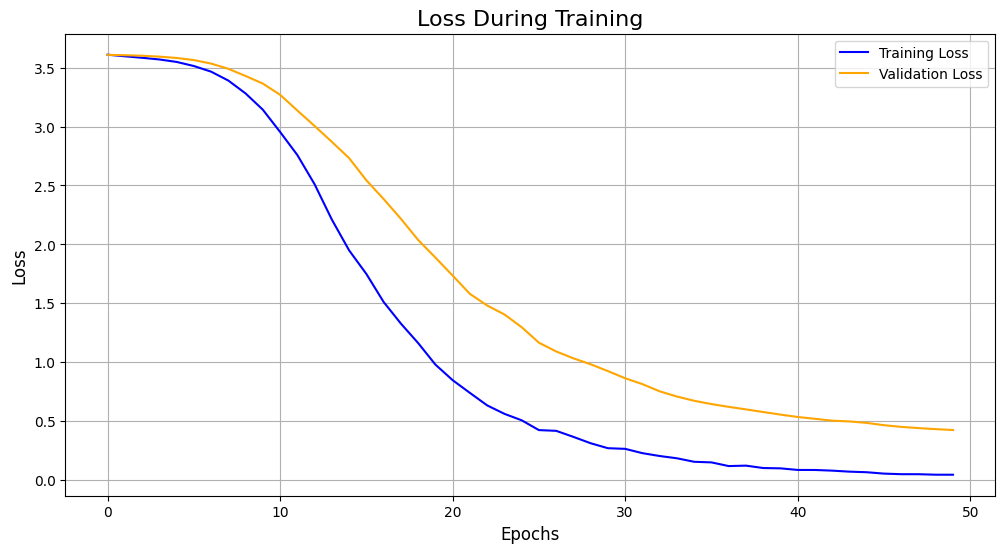

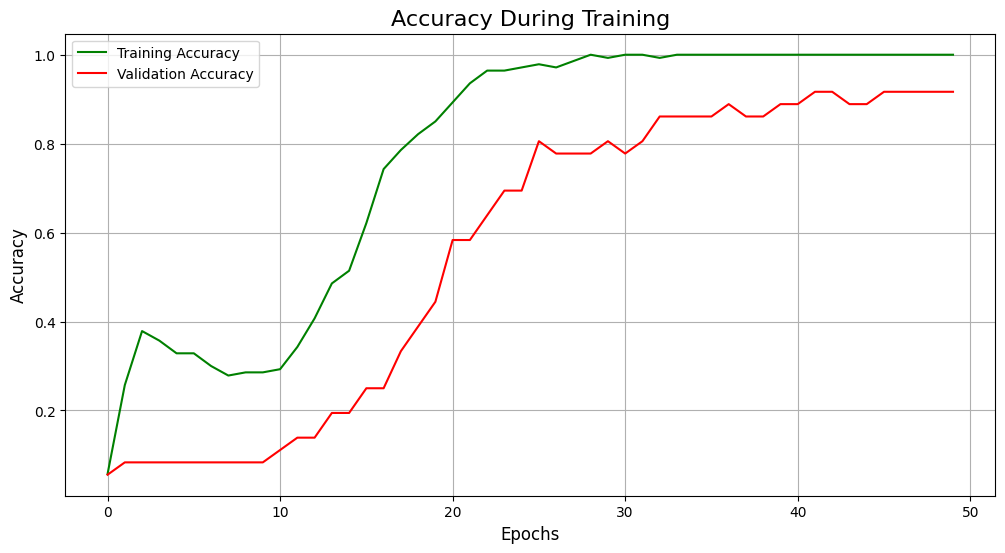

In [22]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'], label='Training Loss', color='blue')
if 'val_loss' in hist.history:
    plt.plot(hist.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss During Training', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(hist.history['accuracy'], label='Training Accuracy', color='green')
if 'val_accuracy' in hist.history:
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy During Training', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid()
plt.show()
